In [11]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from shapely.geometry import Polygon

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from helper import compute_ats_bounding_boxes, compute_ts_road_map

In [12]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [13]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

# Labeled dataset

In [14]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [15]:
labeled_scene_index = np.arange(106, 134)
train_inds = labeled_scene_index[:23]
val_inds = labeled_scene_index[23:]

In [16]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.

transform_train = transforms.Compose([torchvision.transforms.Resize((256,256)),
                                transforms.ToTensor(), 
                                transforms.Normalize([ 0.485, 0.456, 0.406 ],[ 0.229, 0.224, 0.225 ]), 
                                AddGaussianNoise(0., 0.1)])
transform_val = transforms.Compose([torchvision.transforms.Resize((256,256)),
                                transforms.ToTensor(), 
                                transforms.Normalize([ 0.485, 0.456, 0.406 ],[ 0.229, 0.224, 0.225 ])])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_inds,
                                  transform=transform_train,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_inds,
                                  transform=transform_val,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1,shuffle=False, num_workers=2)

In [17]:
len(labeled_trainset), len(trainloader)

(2898, 1449)

In [18]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


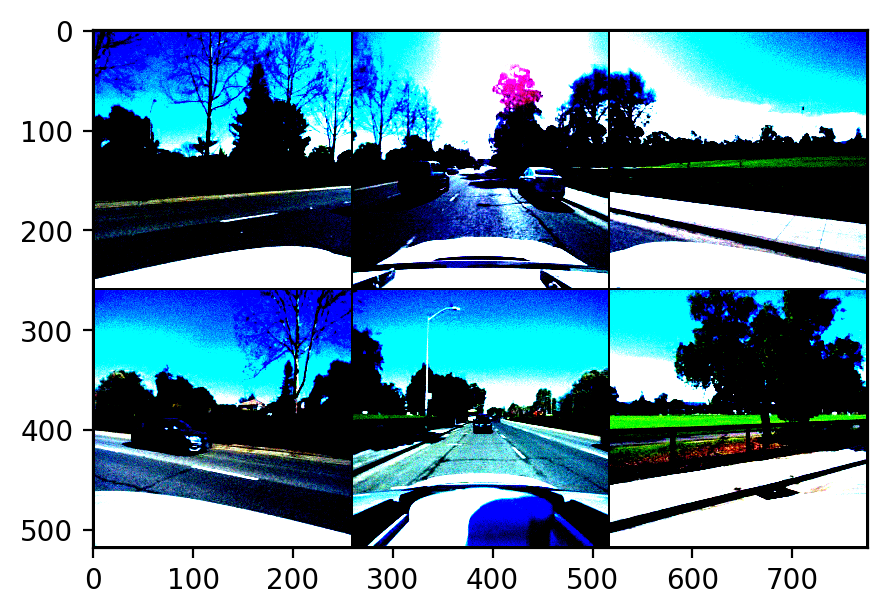

In [19]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))

## Modeling 

In [20]:
target[0]['bounding_box']

tensor([[[ -4.2011,  -4.2056,  -8.9800,  -8.9845],
         [  8.1952,   6.3884,   8.2067,   6.3999]],

        [[-19.3388, -19.3436, -23.9178, -23.9225],
         [  1.0478,  -0.8820,   1.0588,  -0.8710]],

        [[ 14.8001,  14.7744,  10.2215,  10.1958],
         [  4.5911,   2.6045,   4.6501,   2.6635]],

        [[ 14.5969,  14.5588,   9.9309,   9.8928],
         [ -2.3605,  -4.2720,  -2.2679,  -4.1793]]], dtype=torch.float64)

In [10]:
import torchvision.models as models
import copy

In [57]:
class DetectionModel(nn.Module):
    def __init__(self,encoder_a,hidden_size):
        super(DetectionModel,self).__init__()
        
        self.hidden_size = hidden_size
        self.resnet_a = torchvision.models.resnet50(pretrained=False) if encoder_a == "resnet50" else\
                            torchvision.models.resnet34(pretrained=False) if encoder_a == "resnet34" else\
                            torchvision.models.resnet18(pretrained=False)
        
        self.resnet_layers_a = list(self.resnet_a.children())
        self.n_a = 2048 if encoder_a == "resnet50" else 512
        
        self.input_block_a = nn.Sequential(*self.resnet_layers_a)[:-1]
        self.input_block_a[0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)        
        
        self.proj1 = nn.Linear(self.n_a,256,bias=False)
        self.L = nn.Linear(256,100,bias=False)
        
        self.rnn = nn.RNN(self.n_a+512,self.hidden_size,batch_first=True,bias=False)
        
        self.coordinate_encoder = nn.Sequential(nn.Linear(8,256,bias=False), 
                                                nn.ReLU(),
                                                nn.Linear(256,512,bias=False), 
                                                nn.ReLU(),
                                                nn.Linear(512,512,bias=False),
                                                nn.ReLU(),
                                                nn.Linear(512,512,bias=False))
        self.coordinate_decoder = nn.Sequential(nn.Linear(self.hidden_size,512,bias=False), 
                                                nn.ReLU(),
                                                nn.Linear(512,512,bias=False), 
                                                nn.ReLU(),
                                                nn.Linear(512,256,bias=False),
                                                nn.ReLU(),
                                                nn.Linear(256,8,bias=False))
        
    def forward(self,x,targets=None):
        if self.training:
            batch_size = x.shape[0]
            n_bboxes = [i['category'].shape[0] for i in targets]
            e = self.input_block_a(x).view(batch_size,self.n_a) #batch_size,512
            predicted_n_cars = F.log_softmax(self.L(F.relu(self.proj1(e))),dim=-1)
            loss = F.nll_loss(predicted_n_cars,torch.tensor(n_bboxes).to(e.device))
            for instance in range(batch_size):
                k = n_bboxes[instance]
                mask = torch.ones((1,k,8),device = e.device)
                if k<=2:
                    m = 1
                elif k<=6:
                    m = 2
                else:
                    m = k//3
                idx = torch.randint(0,k,(m,),device = e.device)
                mask[:,idx] = 0
                ti = targets[instance]['bounding_box']
                t = (torch.stack(sorted(ti,key=lambda x:x[0,2]))).view(-1,8).unsqueeze(0).to(e.device).float()
                
                rnn_input = self.coordinate_encoder(t*mask) #1,num_boxes,512
                rnn_input_concat = torch.cat((rnn_input,e[instance].unsqueeze(0).unsqueeze(0).repeat(1,k,1)),dim=-1)
                output,_ = self.rnn(rnn_input_concat)
                decoded = self.coordinate_decoder(output)#1,num_bboxes,8
                
                loss+=F.mse_loss(decoded[:,idx],t[:,idx].to(e.device))
                dhi = (t[:,idx,0]-t[:,idx,2])-(decoded[:,idx,0]-decoded[:,idx,2])
                dwi = (t[:,idx,4]-t[:,idx,5])-(decoded[:,idx,4]-decoded[:,idx,5])
                loss+=torch.mean(dhi**2+dwi**2)
                #print(loss)
                iou_matrix = compute_ats_bounding_boxes_train(decoded[0].view(-1,2,4),targets[instance]['bounding_box'].to(e.device).float())
                loss+= 100*F.mse_loss(iou_matrix,torch.ones(iou_matrix.shape))
                #print(loss)
                
            return loss
        else:
            batch_size = x.shape[0]
            e = self.input_block_a(x).view(batch_size,self.n_a) #batch_size,512
            num_cars = torch.argmax(F.log_softmax(self.L(F.relu(self.proj1(e))),dim=-1),-1)#batch_size,num_cars
            predictions = []
            for instance in range(batch_size):
                k = num_cars[instance]+1
                rnn_input = self.coordinate_encoder(torch.zeros((1,k,8),device = e.device)) #1,num_boxes,512
                rnn_input_concat = torch.cat((rnn_input,e[instance].unsqueeze(0).unsqueeze(0).repeat(1,k,1)),dim=-1)
                output,_ = self.rnn(rnn_input_concat)
                decoded = self.coordinate_decoder(output)#1,num_bboxes,8
                predictions.append(decoded[0].view(-1,2,4))
            return predictions

In [58]:
def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

def compute_ats_bounding_boxes_train(boxes1, boxes2):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
#             if condition_matrix[i][j]:
            iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])
    return iou_matrix

In [59]:
device = torch.device('cuda:0')
model = DetectionModel('resnet18',512).to(device)
lr = 5e-5
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer  = torch.optim.SGD(model.parameters(), lr=0.0005,momentum=0.9, weight_decay=0.0005)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

In [60]:
def validation(model,val_loader,device):
    model.eval()
    with torch.no_grad():
        tse_bbox = 0.
        total = 0.
        for i,(sample, target, road_image,extra) in enumerate(val_loader):
            total+=1.0  
            s = sample.to(device)
            input_img = prepare_sample(s)
            #input_img = torch.stack(sample).to(device)
            batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
            predicted = model(input_img.view(batch_size,-1,height,width))
            o = predicted[0]
            tse_bbox+=compute_ats_bounding_boxes(o,target['bounding_box'][0].to(device).float()).float()
        return (tse_bbox/total).item()

In [61]:
def prepare_sample(sample):
    a = torch.cat((sample[:,0],sample[:,1],sample[:,2]),dim=2)
    b = torch.cat((sample[:,3],sample[:,4],sample[:,5]),dim=2)
    c = torch.cat((a,b),dim=-3)
    return c

In [62]:
def train(model,train_loader,val_loader,optimizer,device,num_epochs = 10):
    max_val = 0
    c_point = 724
    #model.load_state_dict(torch.load('resnet_detection_adam.pth'))
    model.train()
    for epoch in range(1,num_epochs+1):
        avg_train_loss_bbox = 0
        for i,(sample, target, road_image, extra) in enumerate(train_loader):
            input_img = prepare_sample(torch.stack(sample).to(device))
            batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
            optimizer.zero_grad()
            
            loss = model(input_img.view(batch_size,-1,height,width),target)
            avg_train_loss_bbox+=loss.item()
            loss.backward()
            optimizer.step()
            if (i+1)%c_point==0:
                val_tse_bbox = validation(model,val_loader,device)
                print('epoch: {} | step: {}/{}  | train loss bbox: {} | val tse bbox: {}'.format(epoch,
                                                                                      (i+1)//c_point,
                                                                                      len(train_loader)//c_point,
                                                                                      round(avg_train_loss_bbox/c_point,3),
                                                                                      val_tse_bbox))
                model.train()
                avg_train_loss_bbox = 0
                if val_tse_bbox>max_val:
                    print('--Saving--')
                    torch.save(model.state_dict(),'bert_detection_meters_biasFalse.pth')
                    max_val = val_tse_bbox
        #scheduler.step()
            

In [ ]:
train(model,trainloader,valloader,optimizer,device,num_epochs = 10)

epoch: 1 | step: 1/2  | train loss bbox: 651.201 | val tse bbox: 0.0
epoch: 1 | step: 2/2  | train loss bbox: 552.164 | val tse bbox: 0.0
epoch: 2 | step: 1/2  | train loss bbox: 543.854 | val tse bbox: 0.0
epoch: 2 | step: 2/2  | train loss bbox: 539.729 | val tse bbox: 0.0


In [19]:
torch.save(model.state_dict(),'bert_detection_meters_biasFalse.pth')

In [47]:
model.eval()
with torch.no_grad():
    sample, target, road_image, extra = labeled_valset[120]
    input_img = prepare_sample(sample.to(device).unsqueeze(0))
    print(input_img.shape)
            #input_img = torch.stack(sample).to(device)
    batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
    decoded = model(input_img.view(batch_size,-1,height,width))
    o = decoded[0].view(-1,2,4)
    #predicted_road_map = torch.sigmoid(predicted_road)>0.5
    #predicted_road_map = (predicted_road_map.squeeze(1)).float()

torch.Size([1, 6, 768, 256])


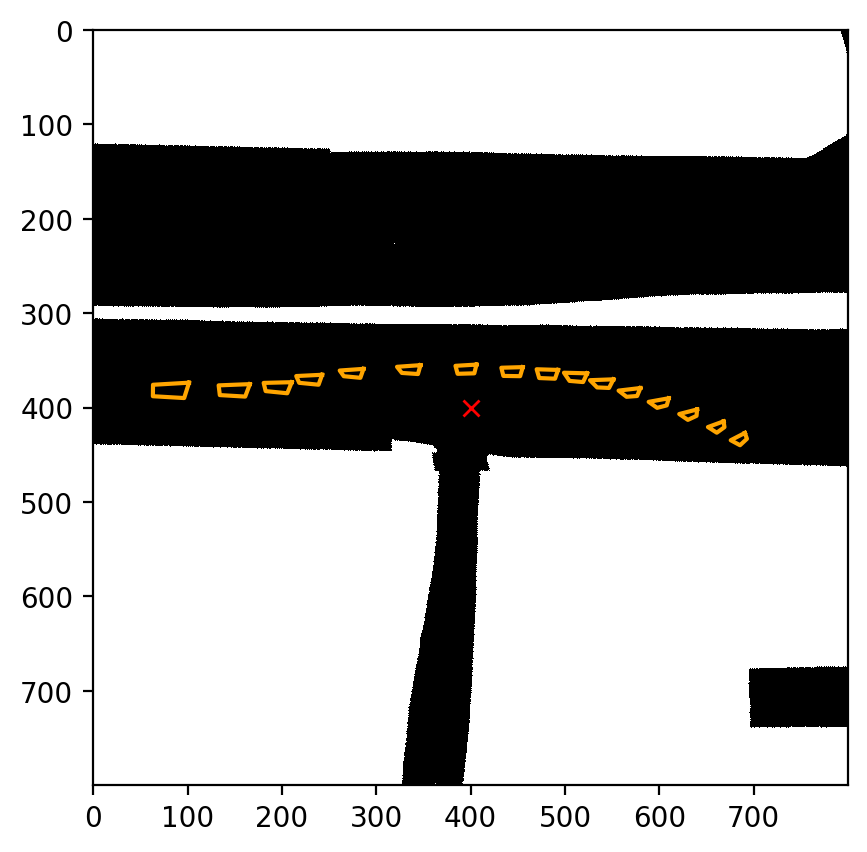

In [48]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image, cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(decoded[0]):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, (bb).cpu(), color=color_list[2]) 

In [24]:
decoded[0]/10

tensor([[ 7.8001,  7.7557,  6.0516,  6.0423, 37.1022, 36.4264, 37.1747, 36.4252],
        [ 9.2618,  9.2266,  7.4337,  7.4692, 38.6081, 37.8891, 38.6909, 37.9439],
        [10.8347, 10.8063,  9.0125,  9.0445, 39.2060, 38.4844, 39.2875, 38.5432],
        [12.3201, 12.2954, 10.5190, 10.5467, 39.4828, 38.7709, 39.5641, 38.8300],
        [13.9573, 13.9357, 12.1868, 12.2103, 39.6363, 38.9391, 39.7178, 38.9968],
        [15.7921, 15.7734, 14.0610, 14.0800, 39.7028, 39.0247, 39.7848, 39.0797],
        [17.8369, 17.8212, 16.1491, 16.1632, 39.7812, 39.1241, 39.8640, 39.1764],
        [20.2953, 20.2833, 18.6625, 18.6723, 39.8275, 39.1963, 39.9115, 39.2450],
        [23.1929, 23.1846, 21.6290, 21.6367, 39.8185, 39.2197, 39.9046, 39.2628],
        [26.4046, 26.4004, 24.9169, 24.9212, 39.8209, 39.2571, 39.9084, 39.2940],
        [30.0345, 30.0351, 28.6325, 28.6328, 39.8360, 39.3117, 39.9254, 39.3416],
        [33.8276, 33.8333, 32.5159, 32.5122, 39.8245, 39.3426, 39.9170, 39.3645],
        [37.6692

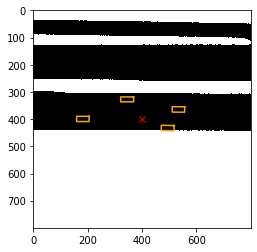

In [24]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image, cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[2]) 

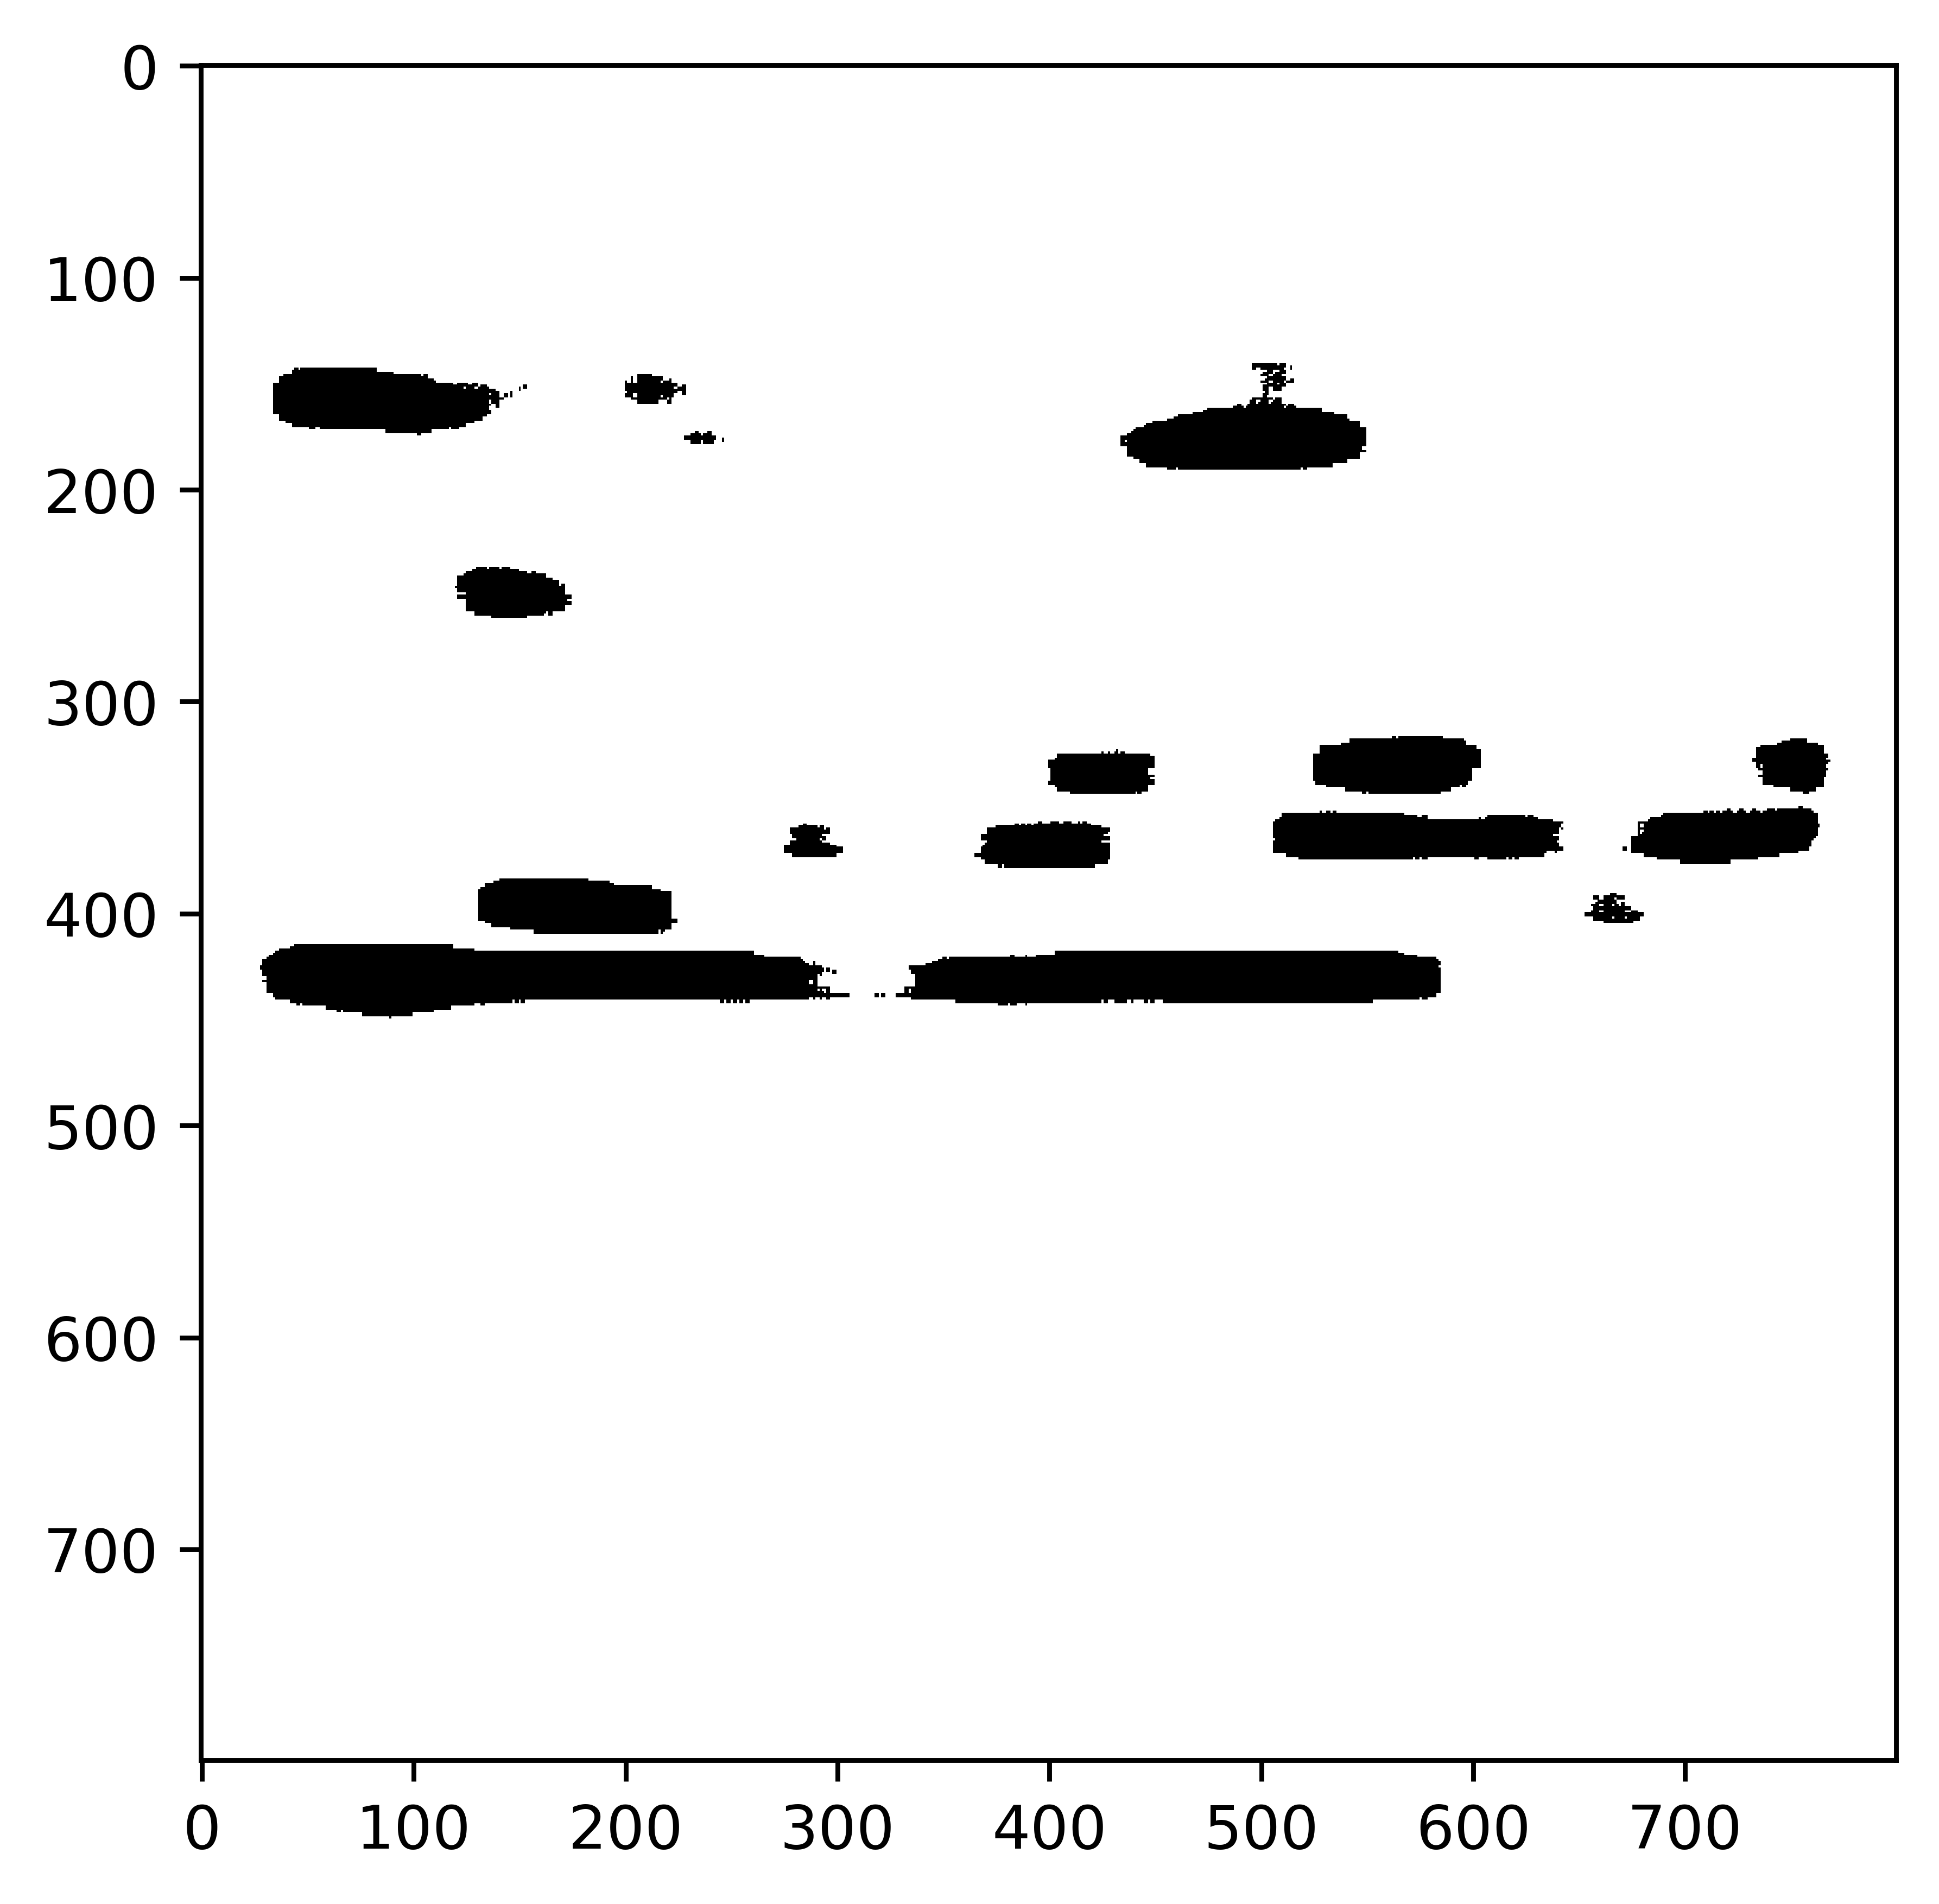

In [32]:
o = z[0]
o[o<0.5]=0
o[o>0.5]=1
plt.imshow(o.cpu().numpy(),cmap='binary')

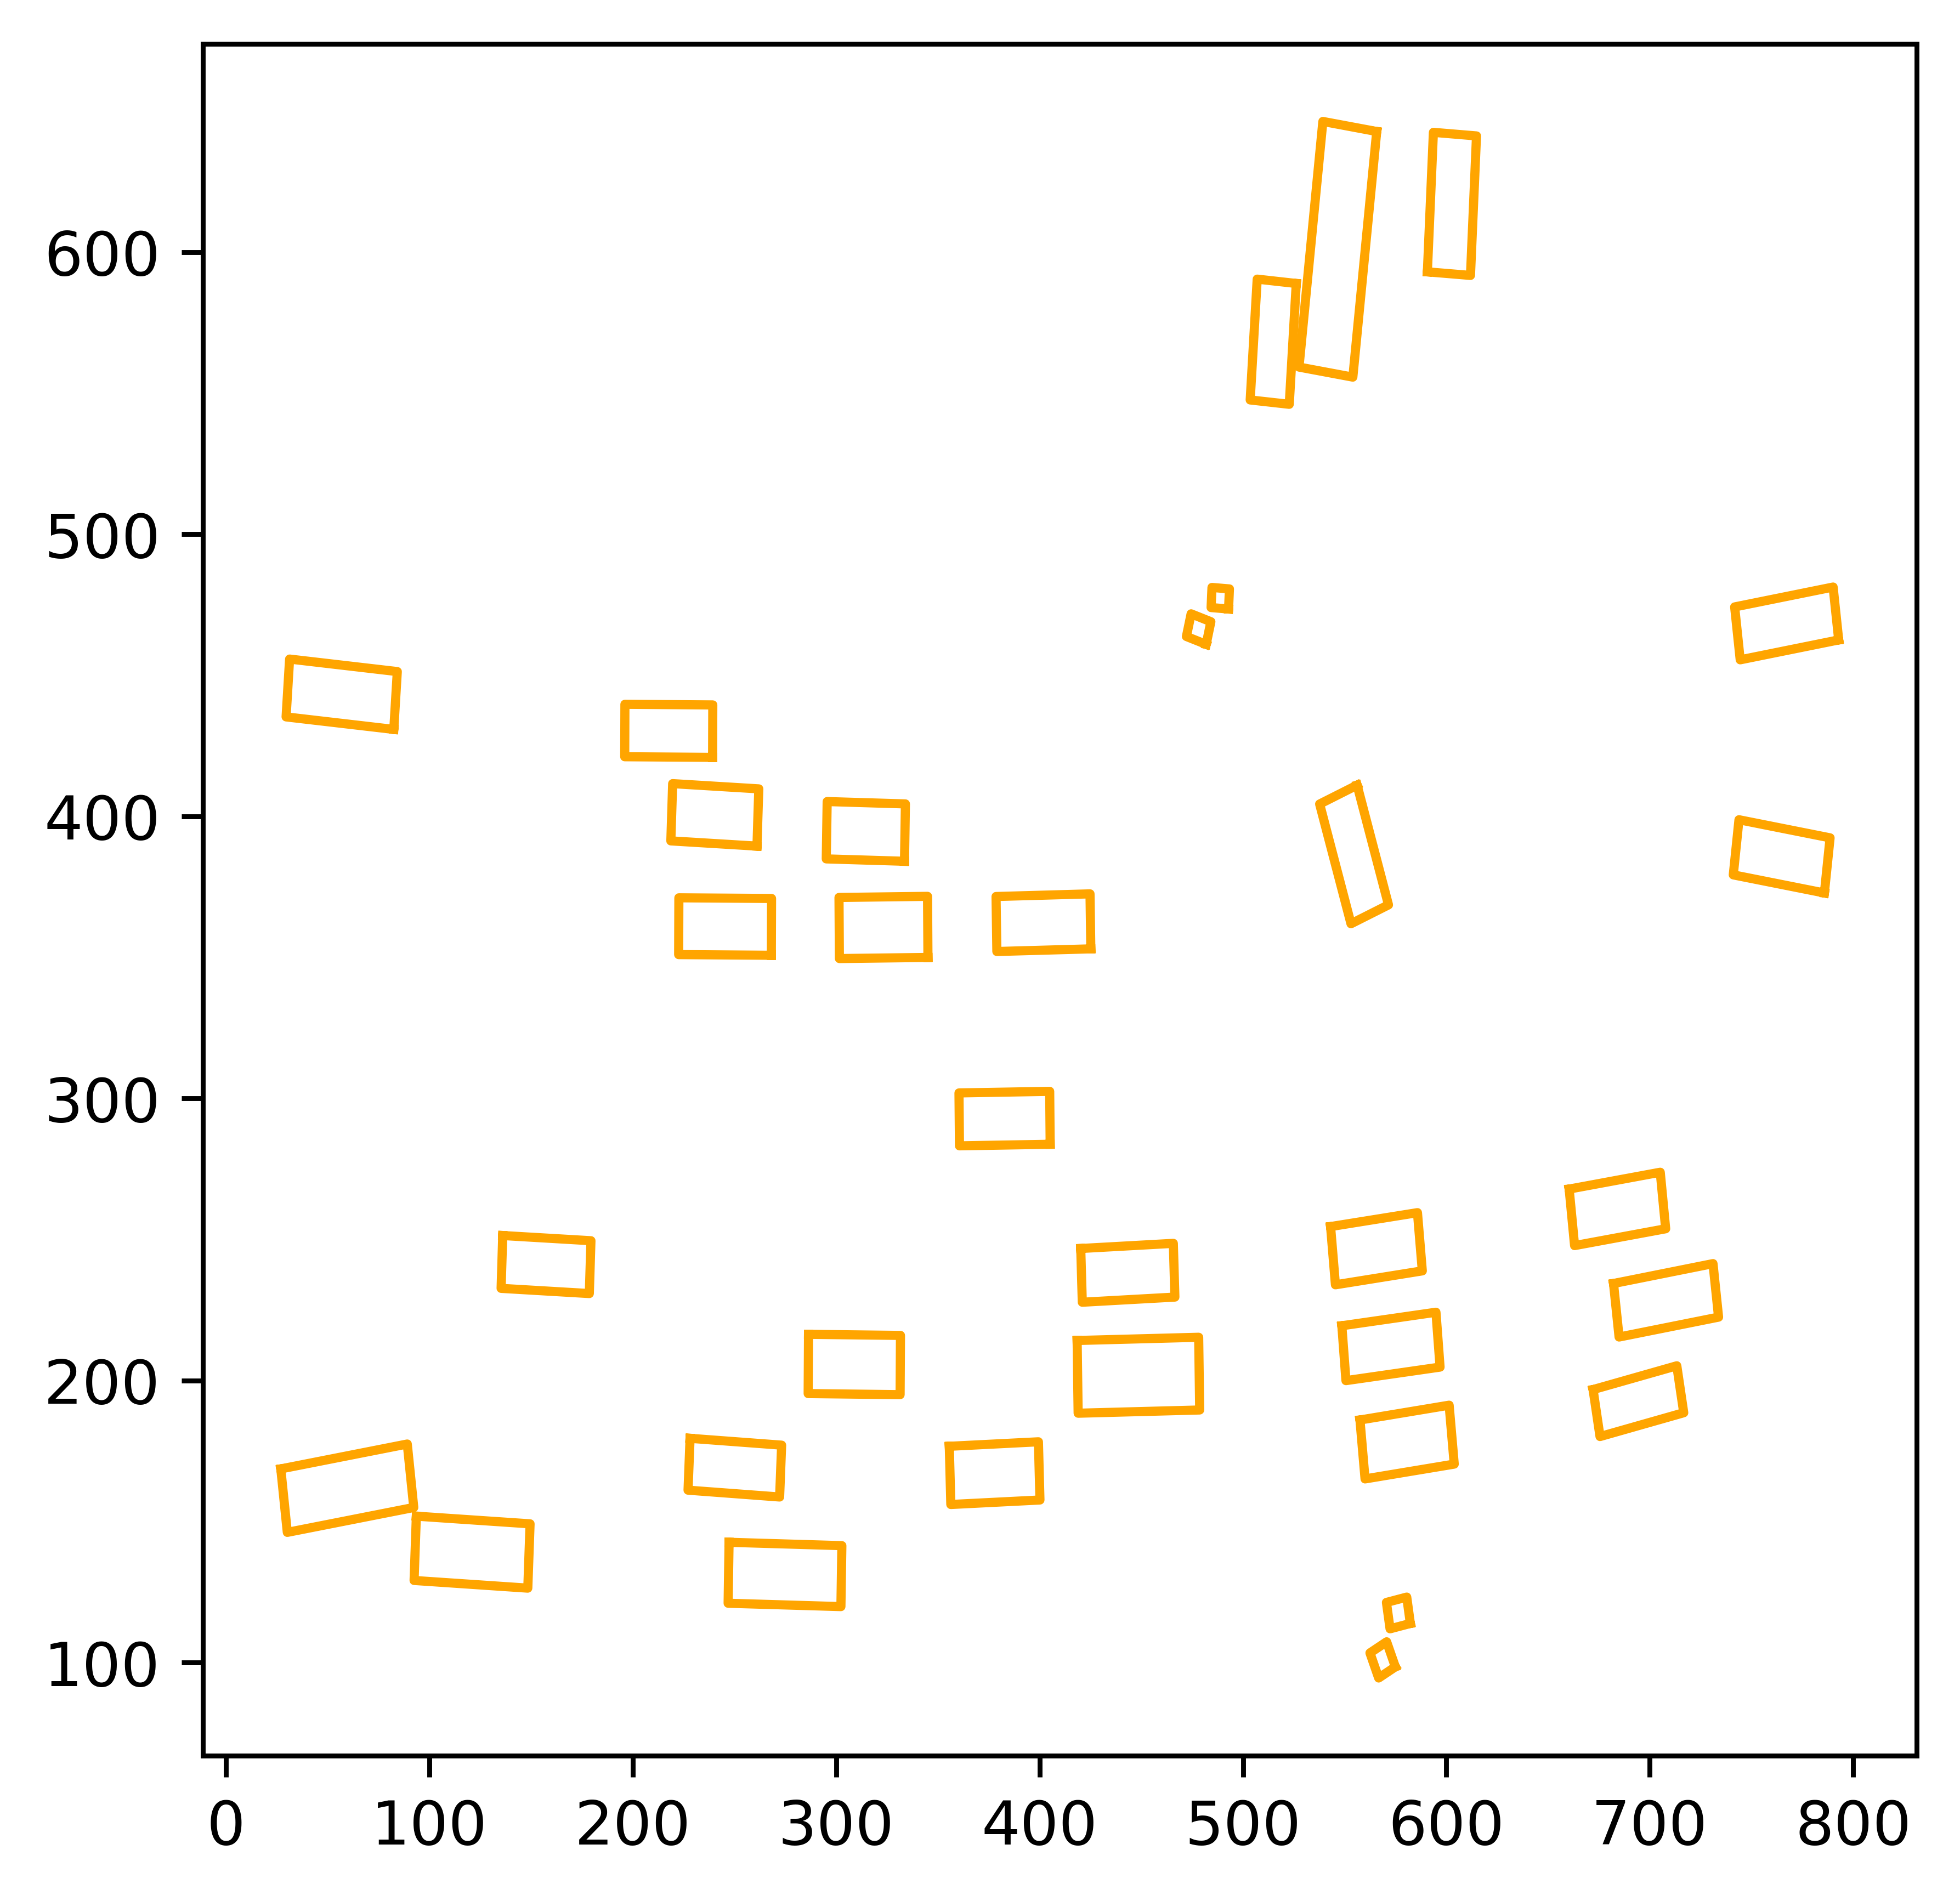

In [31]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

#ax.imshow(road_image, cmap ='binary')
#ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb.view(2,4).cpu(), color=color_list[2]) 

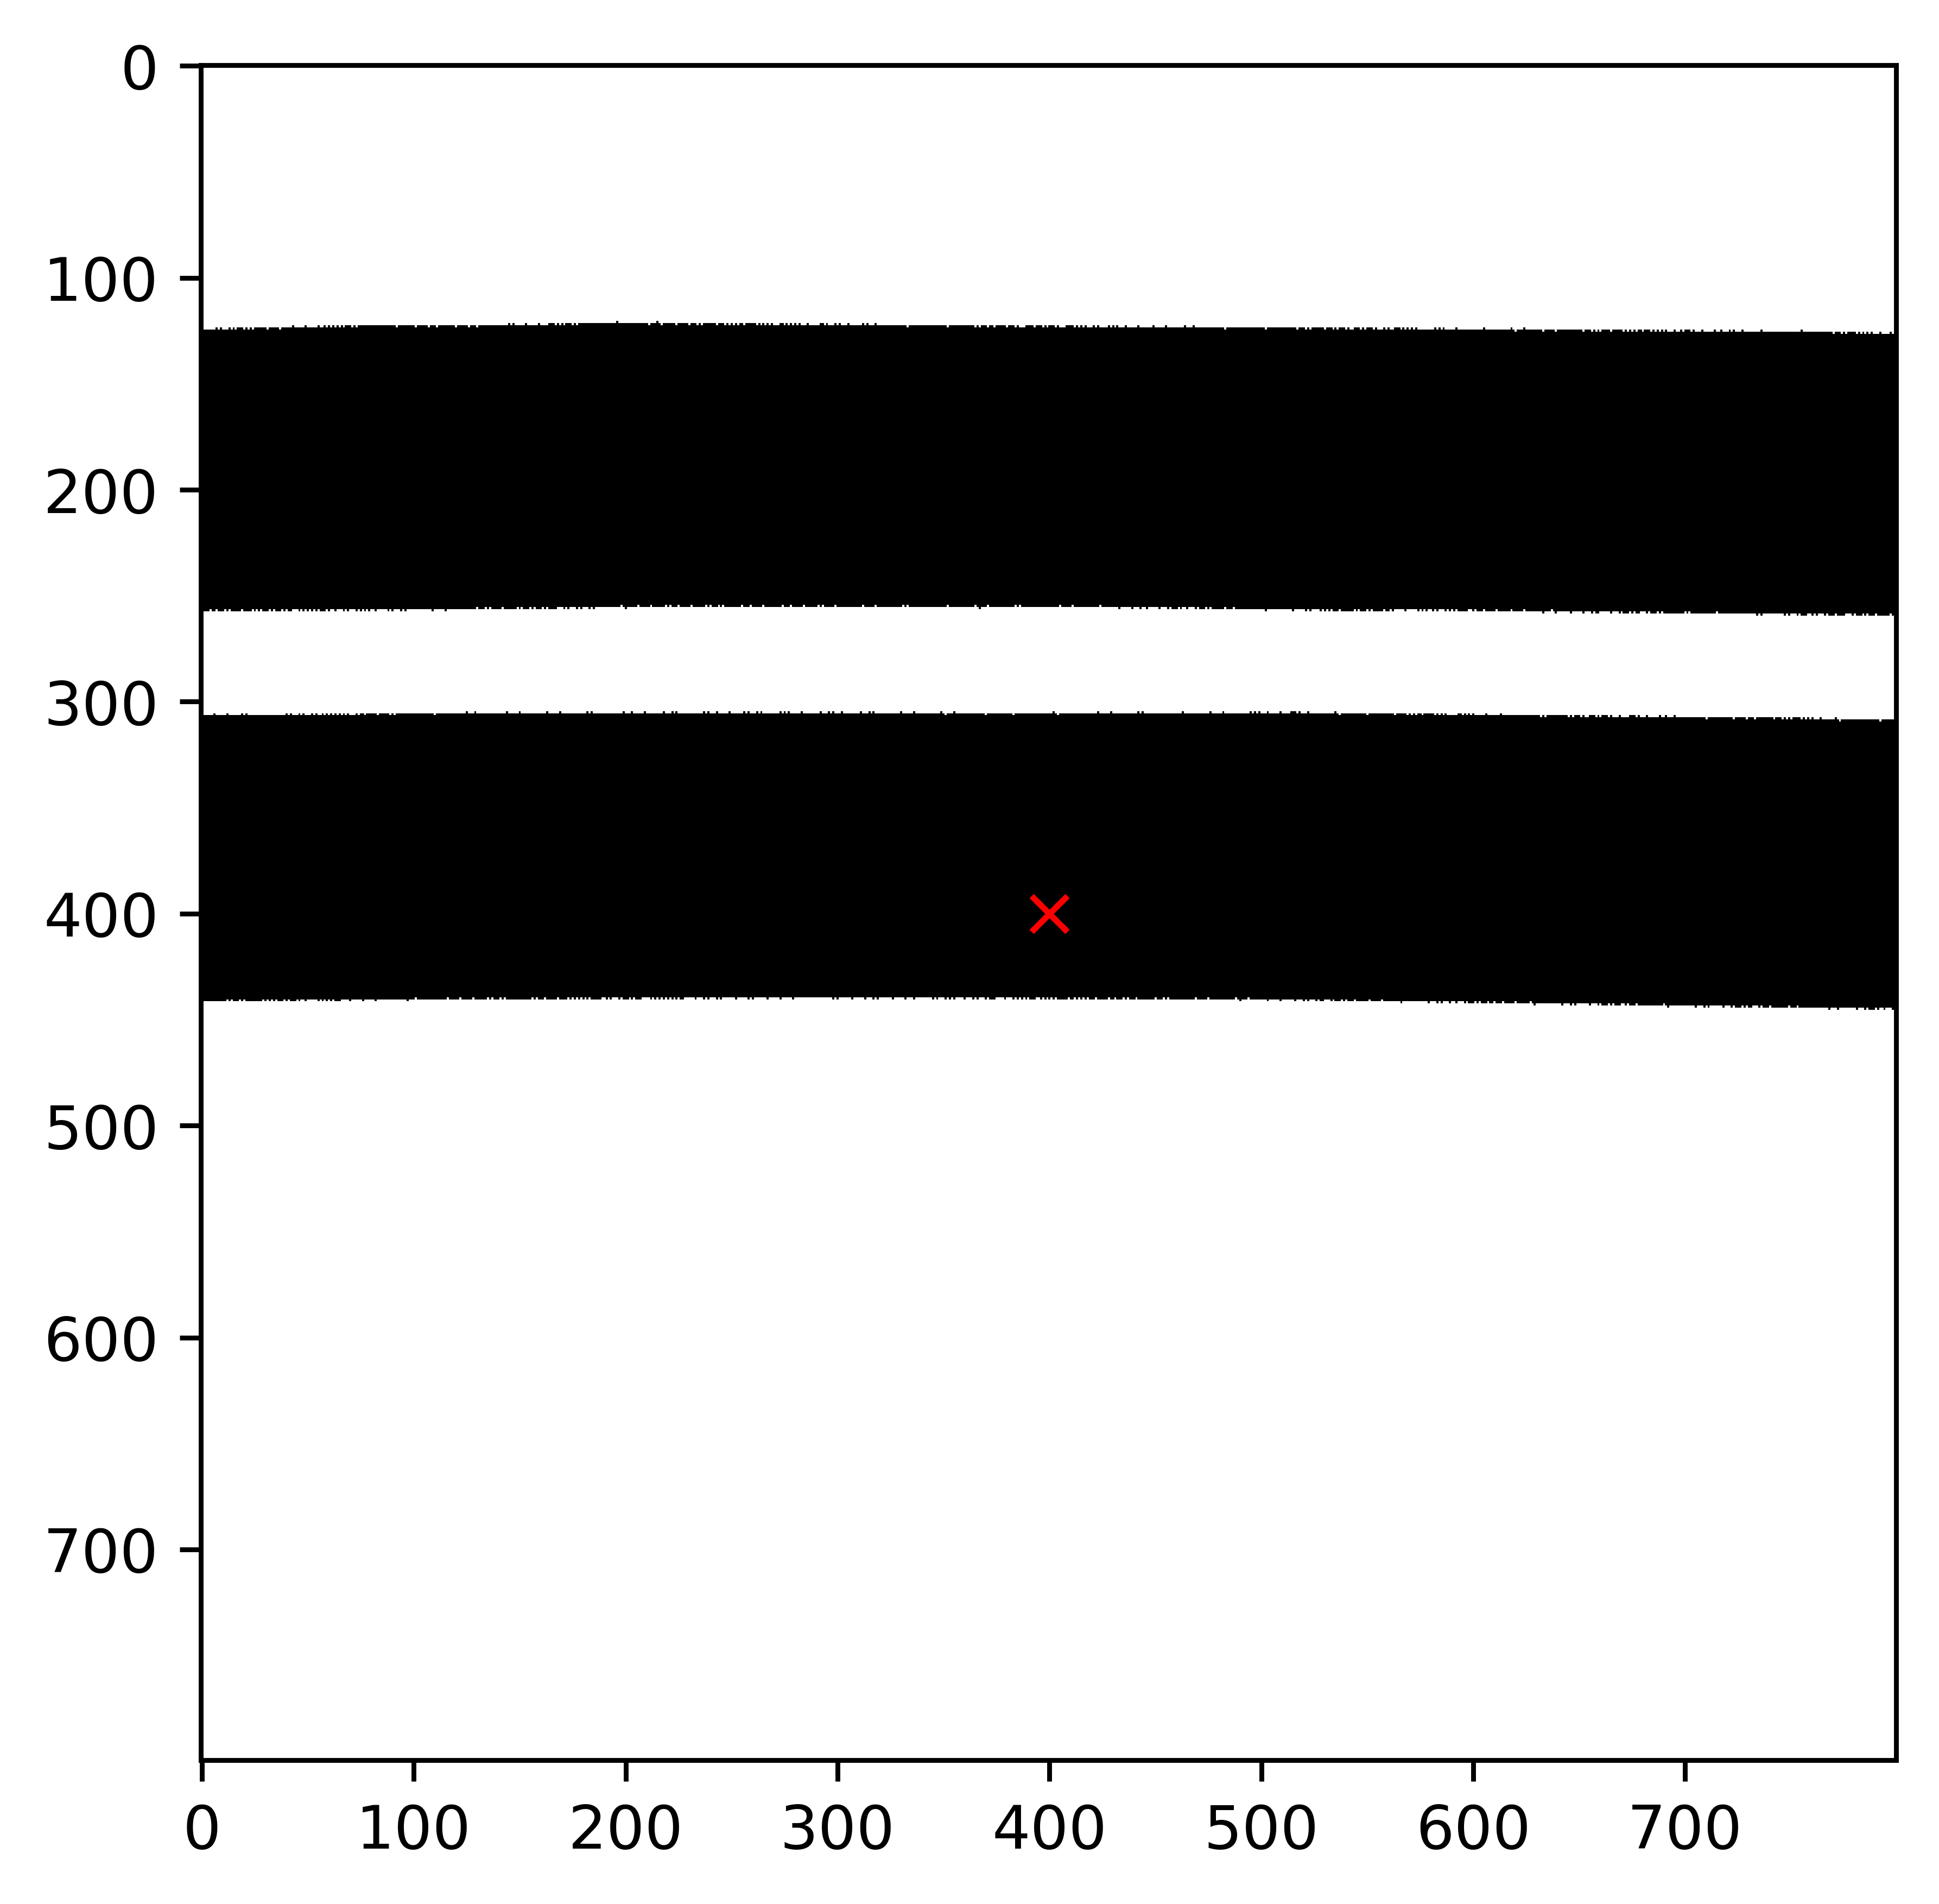

In [25]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image, cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(cars):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb.view(2,4).cpu(), color=color_list[2]) 

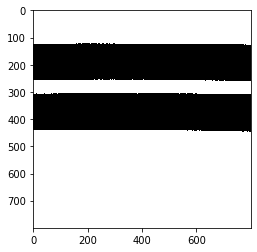

In [47]:
plt.imshow(road_image, cmap='binary')

## Extra Info

There is some extra information you can use in your model, but it is optional.

# Visualize the bounding box

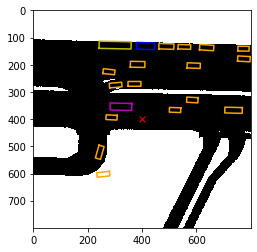

In [56]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$
